# Session 03 - Temporal Difference Learning - Assignment

## 1. Cliff walking

Implement Q-learning and SARSA to solve the cliff walking environment. The cliff walking environment is part of the gymgrid package. 
To install gymgryd: **pip3 install gymgrid**. More information can be found here: https://pypi.org/project/gymgrid/.
The goal for the agent is to find its way from start to finish without falling from the cliff. This is a standard episodic task, with start and goal states, and the usual actions causing movement up, down, right, and left. Reward is -1 on all transitions except those into the region marked Cliff. Stepping into this region incurs a reward of optimal path -100 and sends the agent instantly back to the start.

- Implement the Q-learning algorithm. Write your own implementation and tune the hyperparameters (learning rate, discount factor, epsilon). Use epsilon decay if necessary. 
- Record the learning history. This means that for each episode you register the total episodic reward. After learning, plot the training history (x-axis = episode number; y-axis: total episodic reward). Especially in the beginning, the episodic rewards can be erratic because the agent is still exploring and has little knowledge of the environment. Therefore it can be a good idea to plot the moving average of the episodic rewards. For example, the average episodic reward achieved over 10 episodes.
- Check if you can make the agent learn faster by using an adaptive learning rate. You start with a high learning rate and you decrease gradually as the agent learns.
- Can you change the reward function in order to make the agent learn faster. For example by changing the reward values or by adding new rewards that make the reward function less sparse.

- Modify you Q-learing implementation to a SARSA implementation.

- Compare Q-learing with SARSA in terms of speed of learning, but especially in terms of the learned policy. 


**Note to myself**: I have to use the conda gym environment for this notebook. I have to go to the conda powershell terminal and type: conda activate gym. Then I can use pip install gymgrid.
*Use the conda gym environment for this notebook.*
- go to conda powershell terminal
- conda activate gym
- pip install gymgrid

In [176]:
# Cliff walking

#import gymgrid #pip install gymgrid
import numpy as np
import pandas as pd
import random
import gym
import matplotlib.pyplot as plt
import copy

In [117]:
# Define the agent
class Qagent:
    def __init__(self, nr_states, nr_actions, alpha, gamma, exploration_rate, decay, init_value, policy_rate):
        self.alpha = alpha
        self.gamma = gamma
        self.exploration_rate = exploration_rate
        self.policy_rate = policy_rate
        self.decay = decay
        self.nr_states = nr_states
        self.nr_actions = nr_actions
        self.current_state = 0
        self.previous_state = 0
        self.possibleActions = [0, 1, 2, 3]
        if init_value != 0:
            self.q_table = np.full((nr_states, nr_actions), init_value)
        else:
            self.q_table = np.zeros((nr_states, nr_actions))
    
    def compute_action(self, state): #state is integer in nr_states()
        self.state = state
        self.r = random.random()
        if self.r <= self.exploration_rate:
            self.action = random.sample(self.possibleActions, 1)[0] # random.sample returns a list() of one item therefore we need to pick the first element [0] of that list
            # print('exploration')
        else:
            self.action = np.argmax(self.q_table[self.state,:])
            # print(self.r, self.exploration_rate, 'exploitation')
        self.exploration_rate = self.exploration_rate*self.decay
        return self.action
    
    def update_qtable(self, new_state, state, reward):
        self.reward = reward
        self.new_state = new_state
        self.state = state
        
        self.r = random.random()
        if self.r <= self.policy_rate:
            self.next_q_value = self.q_table[self.new_state, random.sample(self.possibleActions, 1)[0]]
        else:
            self.next_q_value = self.q_table[self.new_state, np.argmax(self.q_table[self.new_state, :])]
        
        self.q_table[self.state, self.action] = (1 - self.alpha)*self.q_table[self.state,self.action]+self.alpha*(self.reward+self.gamma*self.next_q_value)
        
        self.alpha = self.alpha * self.decay


In [118]:
# Calculate Moving averages
def moving_average(source, window_size=2):
    moving_averages = []
    i = 0
    while i < len(source) - window_size + 1:
        window = source[i : i + window_size]
        window_average = round(sum(window)/window_size, 2)
        moving_averages.append(window_average)
        i += 1
    return moving_averages

In [123]:
# load the environment
env = gym.make('cliff-v0')

# Define a walking function
def cliffwalk(James):
    threshold = 600
    new_state = env.reset()
    done = False
    t = 0
    episode_reward = 0
    while not done:
        t += 1
        current_state=new_state
        #env.render()
        action = James.compute_action(state=current_state)
        new_state, reward, done, _ = env.step(action)
        if reward == 0: reward = 10
        if reward == -100 : reward = -200
        if t > threshold: 
            done = True
            reward -= 100
        James.update_qtable(new_state,current_state,reward)
        episode_reward = episode_reward + reward
    timesteps = t
    return episode_reward, timesteps

# Gymgrid properties
env_states = env.observation_space.n # width = 12 x height = 4
env_actions = env.action_space.n 

In [125]:
# Define an ActionMap creation
def CreateActionMap(inputlist:list,width:int,height:int):
    """
    This function takes the highest q-value for a state and maps it on the cliff-v0 environment.
    X stands for 0-values = cliffs and end-point
    The inputlist is the q-value table from the agent.
        Cliff / End         [X]
        Action 0 = Left     [<]
        Action 1 = Right    [>]
        Action 2 = Up       [^]
        Action 3 = Down     [v]
    """
    A = np.array(inputlist)
    res = A.max(axis=1)
    actionmap = np.zeros((height,width)).tolist()
    for i in range(width):
        for j in range(height):
            k = 4 * i + j
            if A[k][0] == 0:
                actionmap[j][i] = 'X'
            elif A[k][0] == res[k]:
                actionmap[j][i] = '<'
            elif A[k][1] == res[k]:
                actionmap[j][i] = '>'
            elif A[k][2] == res[k]:
                actionmap[j][i] = '^'
            elif A[k][3] == res[k]:
                actionmap[j][i] = 'v'
    actionmap = np.array(actionmap)
    a = copy.deepcopy(actionmap)
    a[0] = actionmap[3]
    a[1] = actionmap[2]
    a[2] = actionmap[1]
    a[3] = actionmap[0]
    return a

Cliff opened for Qagent with Learning Rate 0.1
Total reward collected is -10441 in 4380 steps.
The average reward per step is -2.3837899543378995
|--------------------|
|Q-Learning Actionmap|
|--------------------|
[['<' 'v' '^' '^' 'v' '>' '^' '^' '^' '^' 'v' '<']
 ['>' '<' 'v' 'v' '<' 'v' '^' '^' 'v' '>' '^' 'v']
 ['<' '>' '>' '>' '>' '<' '^' '>' '^' '^' '>' 'v']
 ['<' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X']]
---------------------------------------------------

Cliff opened for Qagent with Learning Rate 0.5
Total reward collected is -7477 in 2036 steps.
The average reward per step is -3.6723968565815324
|--------------------|
|Q-Learning Actionmap|
|--------------------|
[['<' 'v' '^' '^' '>' '>' '>' '>' 'v' 'v' '>' 'v']
 ['<' '<' '>' '<' 'v' '>' '>' '>' '>' '>' '>' 'v']
 ['^' '>' '>' '^' '^' '>' '>' '>' '>' '^' '>' 'v']
 ['<' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X']]
---------------------------------------------------

Cliff opened for Qagent with Learning Rate 0.9
Total re

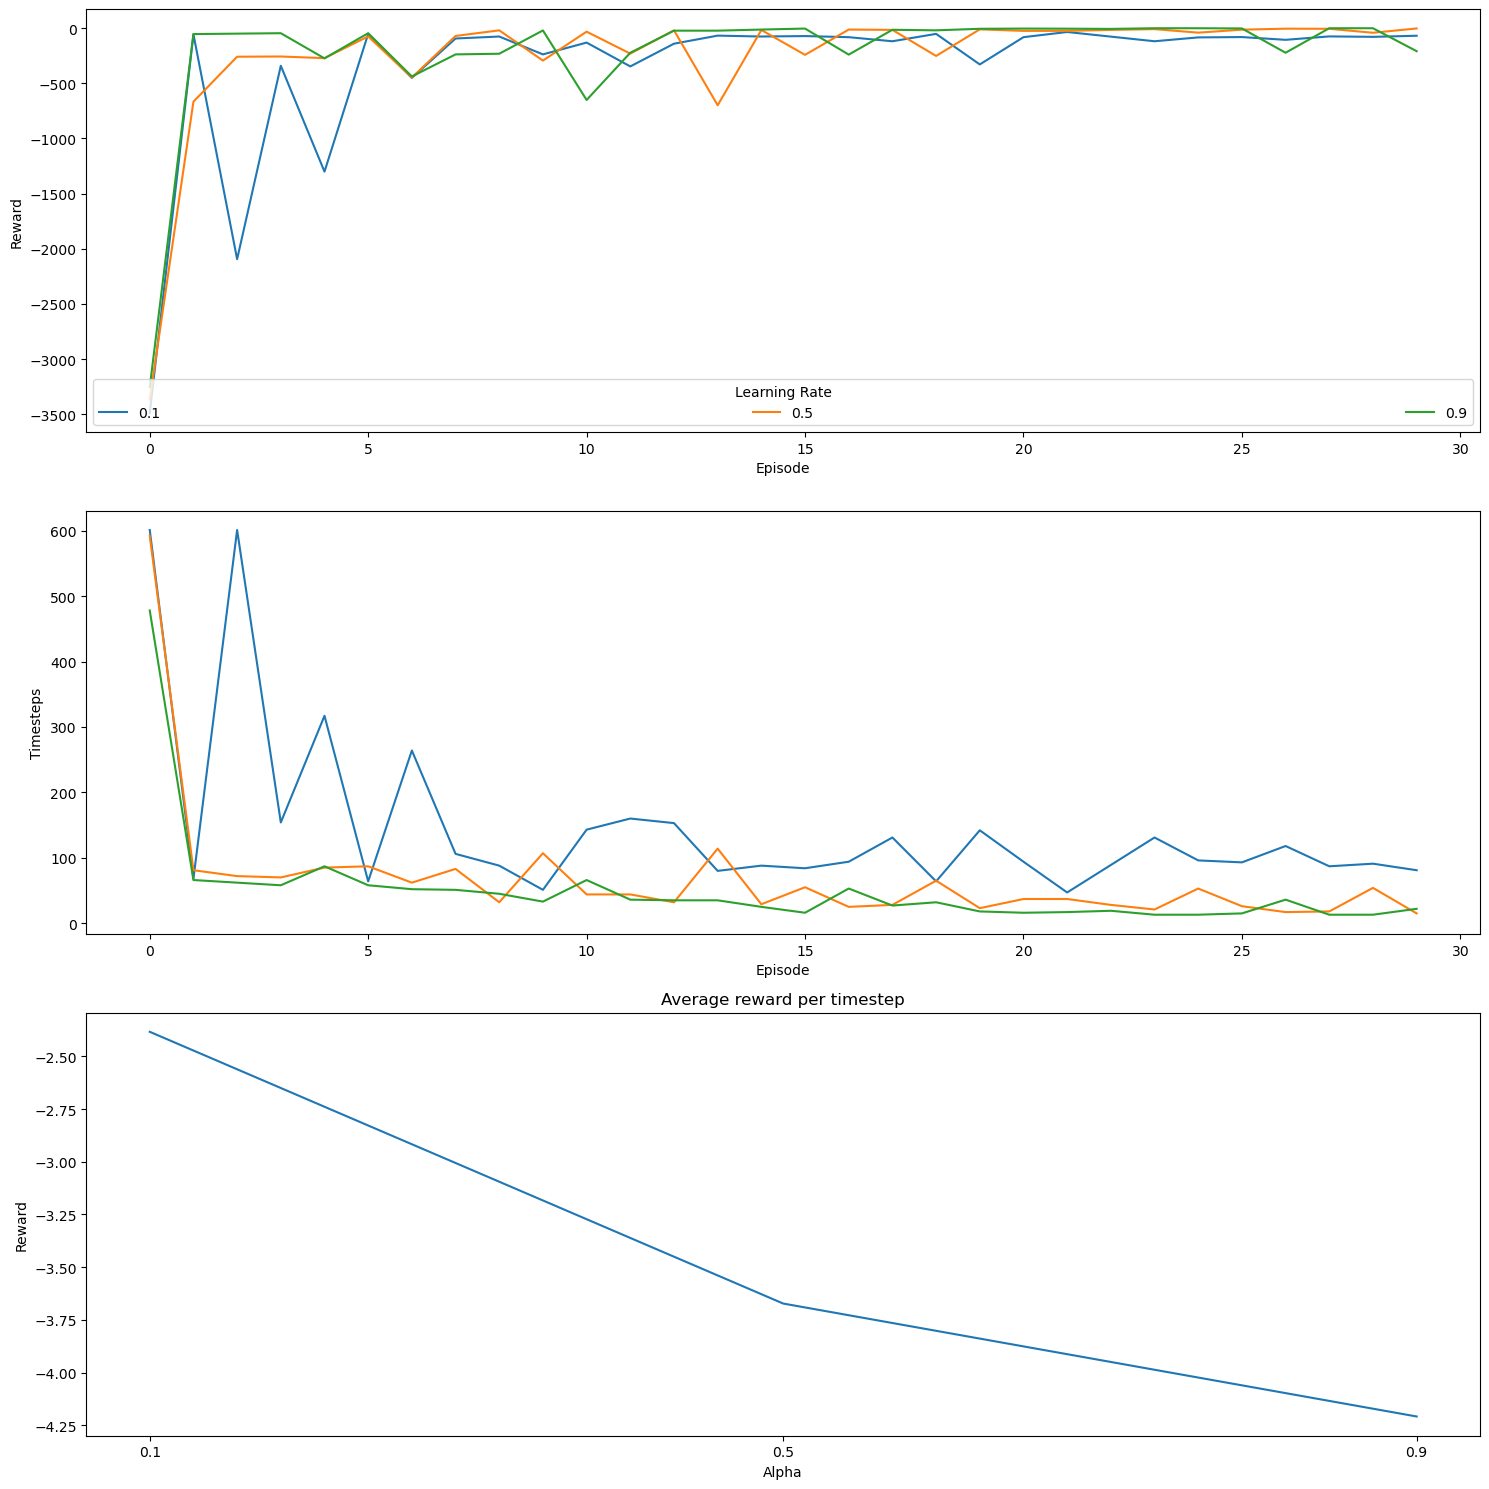

In [165]:
# Hyperparameter tuning for Alpha
# cliff-v0 properties for ActionMap
width = 12
height = 4

# Episode properties
episodes = 30

# Qagent properties
alphas = [0.1, 0.5, 0.9]
gammas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
decay = 0.9995

# Q-learning
QLepsilons = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
QLpolicy = 0

# Initialize collections
QLepisode_rewards = []
QLepisode_timesteps = []

normalized = []
# Default values when not tuned
alpha = alphas[2]
gamma = gammas[8]
epsilon = QLepsilons[2]

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(15,15))


for alpha in alphas:
    # Initialize collections
    QLepisode_rewards = []
    QLepisode_timesteps = []
    QL_James = Qagent(env_states, env_actions, alpha=alpha, gamma=gamma, exploration_rate=epsilon, decay=decay, init_value=0, policy_rate=QLpolicy)

    print("Cliff opened for Qagent with Learning Rate {}".format(alpha))
    for i in range(episodes):
        # Q-learning
        Qreward, Qtimestep = cliffwalk(QL_James)
        QLepisode_rewards.append(Qreward)
        QLepisode_timesteps.append(Qtimestep)
        #print("Q-Learning with reward {0} in {1} timesteps in episode {2}".format(Qreward, Qtimestep, i))

    env.close()
    ax1.plot(QLepisode_rewards, label="{}".format(alpha))
    ax2.plot(QLepisode_timesteps, label="{}".format(alpha))
    normalized.append(np.sum(QLepisode_rewards)/np.sum(QLepisode_timesteps))
    QLepisode_mean_rewards = moving_average(QLepisode_rewards, 10)
    QL_actionmap = CreateActionMap(QL_James.q_table, width, height)
    print('Total reward collected is {0} in {1} steps.'.format(np.sum(QLepisode_rewards),np.sum(QLepisode_timesteps)))
    print('The average reward per step is {}'.format(np.sum(QLepisode_rewards)/np.sum(QLepisode_timesteps)))
    print('|--------------------|')
    print('|Q-Learning Actionmap|')
    print('|--------------------|')
    print(QL_actionmap)
    print('---------------------------------------------------')
    print('')
print('Cliff closed')
ax1.set_ylabel('Reward')
ax2.set_ylabel('Timesteps')
ax1.set_xlabel('Episode')
ax2.set_xlabel('Episode')
ax3.plot(alphas,normalized)
ax3.set_title('Average reward per timestep')
ax3.set_ylabel('Reward')
ax3.set_xlabel('Alpha')
ax3.set_xticks(alphas)
ax1.legend(title="Learning Rate", loc='lower center', ncols=10, mode="expand" )

fig.tight_layout()
plt.show()

Cliff opened for Qagent with Learning Rate 0.9 and Discount Factor 0.1
Total reward collected is -8819 in 2582 steps.
The average reward per step is -3.4155693261037956
|--------------------|
|Q-Learning Actionmap|
|--------------------|
[['<' '<' '>' '>' '>' '>' '^' '<' '^' '>' 'v' 'v']
 ['^' 'v' '<' '>' '>' '<' '>' '>' '>' '>' '>' 'v']
 ['^' '>' '<' '^' '^' '^' '>' '>' '>' '>' '>' 'v']
 ['v' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X']]
---------------------------------------------------

Cliff opened for Qagent with Learning Rate 0.9 and Discount Factor 0.5
Total reward collected is -6722 in 1679 steps.
The average reward per step is -4.003573555687909
|--------------------|
|Q-Learning Actionmap|
|--------------------|
[['v' 'v' '>' '<' '>' '>' '>' 'v' 'v' 'v' '>' 'v']
 ['^' '>' '>' '>' '>' '>' '>' '>' '>' 'v' 'v' 'v']
 ['^' '>' '>' '>' '>' '>' '>' '>' '>' '>' '>' 'v']
 ['^' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X']]
---------------------------------------------------

Cliff ope

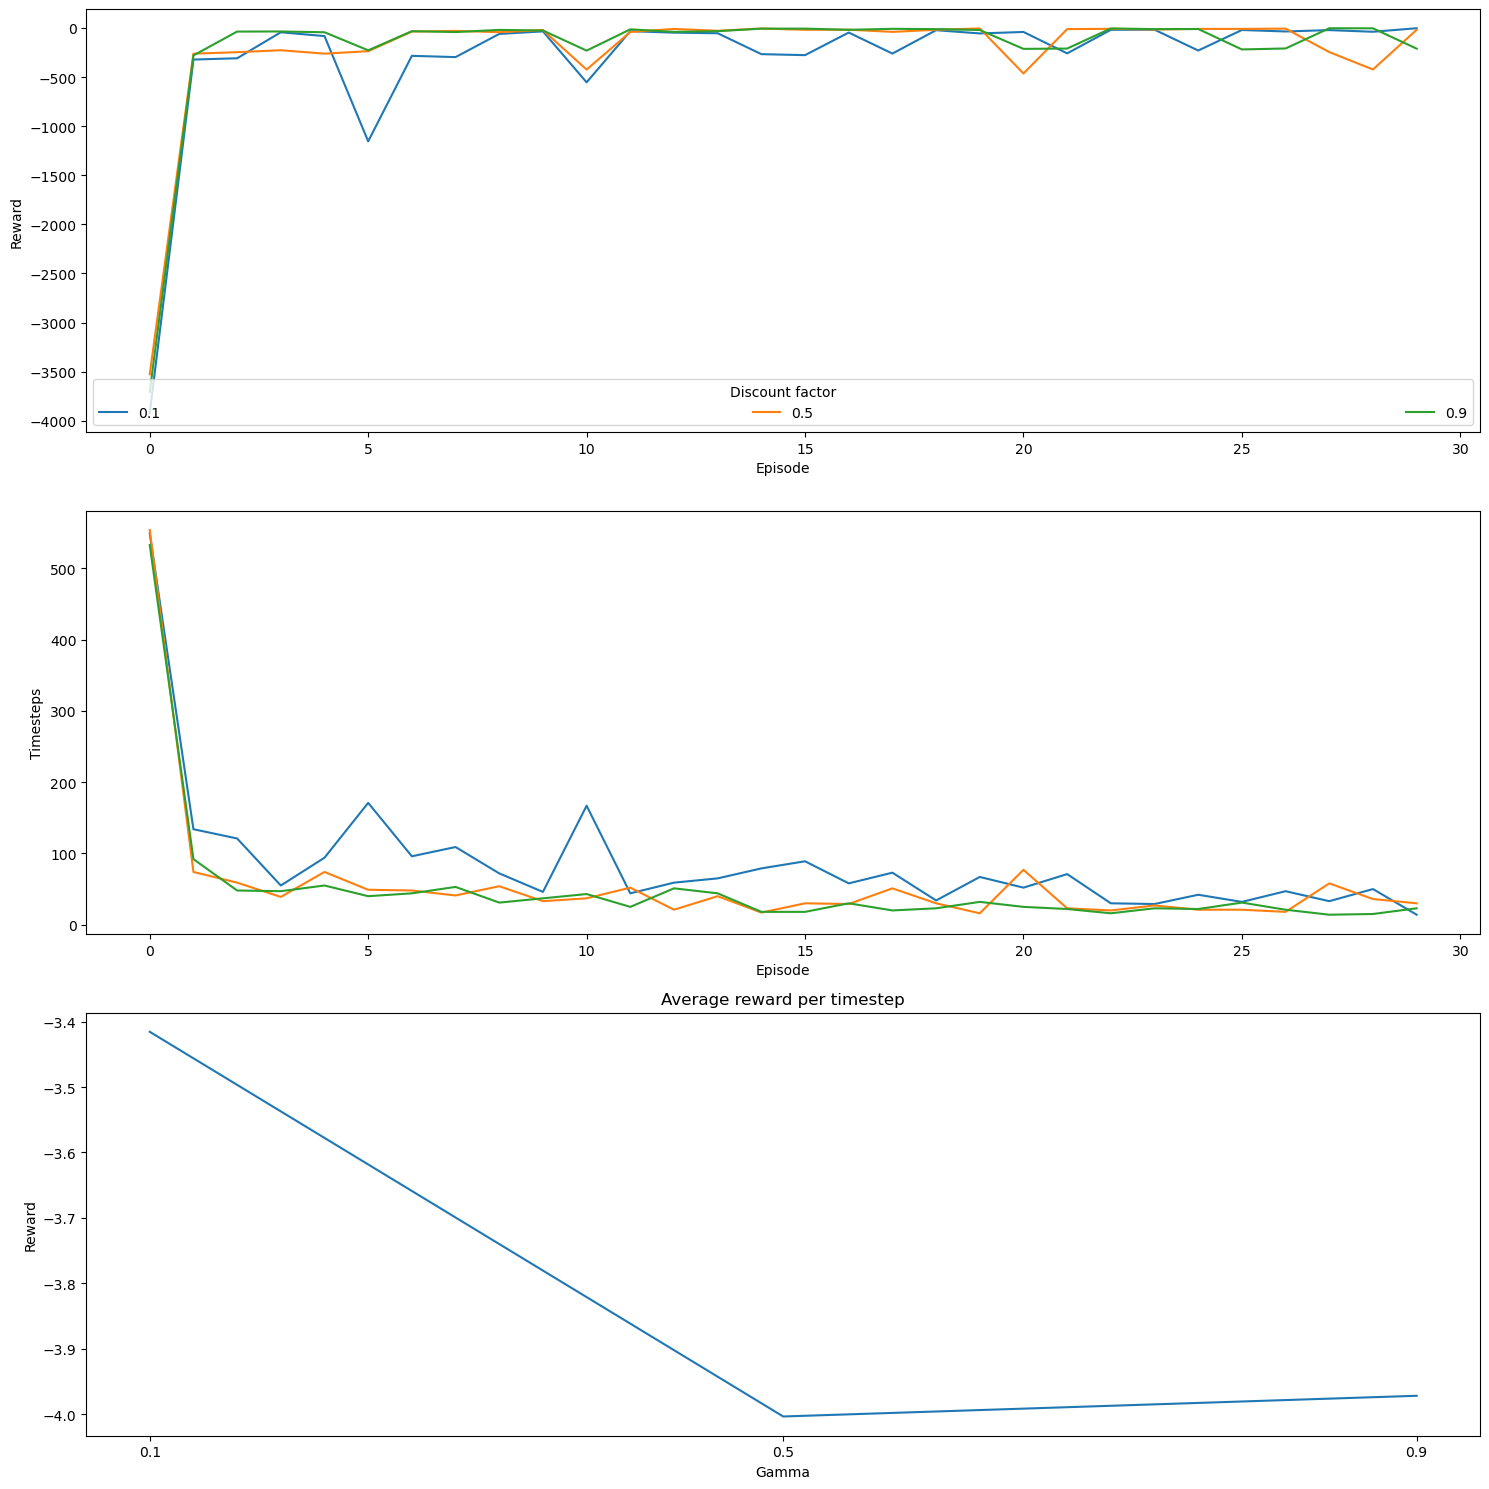

In [173]:
# Hyperparameter tuning for Gamma
# cliff-v0 properties for ActionMap
width = 12
height = 4

# Episode properties
episodes = 30

# Qagent properties
alphas = [0.1, 0.5, 0.9]
gammas = [0.1, 0.5, 0.9]
decay = 0.9995

# Q-learning
QLepsilons = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
QLpolicy = 0

# Initialize collections
QLepisode_rewards = []
QLepisode_timesteps = []

normalized = []
# Default values when not tuned
alpha = alphas[2]
gamma = gammas[2]
epsilon = QLepsilons[2]

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(15,15))


for gamma in gammas:
    # Initialize collections
    QLepisode_rewards = []
    QLepisode_timesteps = []
    QL_James = Qagent(env_states, env_actions, alpha=alpha, gamma=gamma, exploration_rate=epsilon, decay=decay, init_value=0, policy_rate=QLpolicy)

    print("Cliff opened for Qagent with Learning Rate {0} and Discount Factor {1}".format(alpha, gamma))
    for i in range(episodes):
        # Q-learning
        Qreward, Qtimestep = cliffwalk(QL_James)
        QLepisode_rewards.append(Qreward)
        QLepisode_timesteps.append(Qtimestep)
        #print("Q-Learning with reward {0} in {1} timesteps in episode {2}".format(Qreward, Qtimestep, i))

    env.close()
    ax1.plot(QLepisode_rewards, label="{}".format(gamma))
    ax2.plot(QLepisode_timesteps, label="{}".format(gamma))
    normalized.append(np.sum(QLepisode_rewards)/np.sum(QLepisode_timesteps))
    QLepisode_mean_rewards = moving_average(QLepisode_rewards, 10)
    QL_actionmap = CreateActionMap(QL_James.q_table, width, height)
    print('Total reward collected is {0} in {1} steps.'.format(np.sum(QLepisode_rewards),np.sum(QLepisode_timesteps)))
    print('The average reward per step is {}'.format(np.sum(QLepisode_rewards)/np.sum(QLepisode_timesteps)))
    print('|--------------------|')
    print('|Q-Learning Actionmap|')
    print('|--------------------|')
    print(QL_actionmap)
    print('---------------------------------------------------')
    print('')
print('Cliff closed')
ax1.set_ylabel('Reward')
ax2.set_ylabel('Timesteps')
ax1.set_xlabel('Episode')
ax2.set_xlabel('Episode')
ax3.plot(gammas,normalized)
ax3.set_title('Average reward per timestep')
ax3.set_ylabel('Reward')
ax3.set_xlabel('Gamma')
ax3.set_xticks(gammas)
ax1.legend(title="Discount factor", loc='lower center', ncols=3, mode="expand" )

fig.tight_layout()
plt.show()

Cliff opened for Qagent with Learning Rate 0.9 and Discount Factor 0.9
Total reward collected is -5062 in 1412 steps.
The average reward per step is -3.584985835694051
|--------------------|
|Q-Learning Actionmap|
|--------------------|
[['^' '^' 'v' 'v' 'v' 'v' '>' '>' 'v' 'v' '>' 'v']
 ['>' '>' '>' '>' '>' '>' '>' '>' '>' 'v' 'v' 'v']
 ['>' '>' '>' '>' '^' '<' '>' '>' '>' '>' '>' 'v']
 ['^' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X']]
---------------------------------------------------

Cliff opened for Qagent with Learning Rate 0.9 and Discount Factor 0.9
Total reward collected is -13050 in 1727 steps.
The average reward per step is -7.556456282570932
|--------------------|
|Q-Learning Actionmap|
|--------------------|
[['v' '<' '^' '<' 'v' '>' '>' '>' '>' '>' 'v' '>']
 ['^' '^' 'v' '>' '>' 'v' '>' 'v' '>' '>' 'v' '<']
 ['>' '>' '>' '>' '>' '>' '>' '>' '>' '>' '>' 'v']
 ['^' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X']]
---------------------------------------------------

Cliff ope

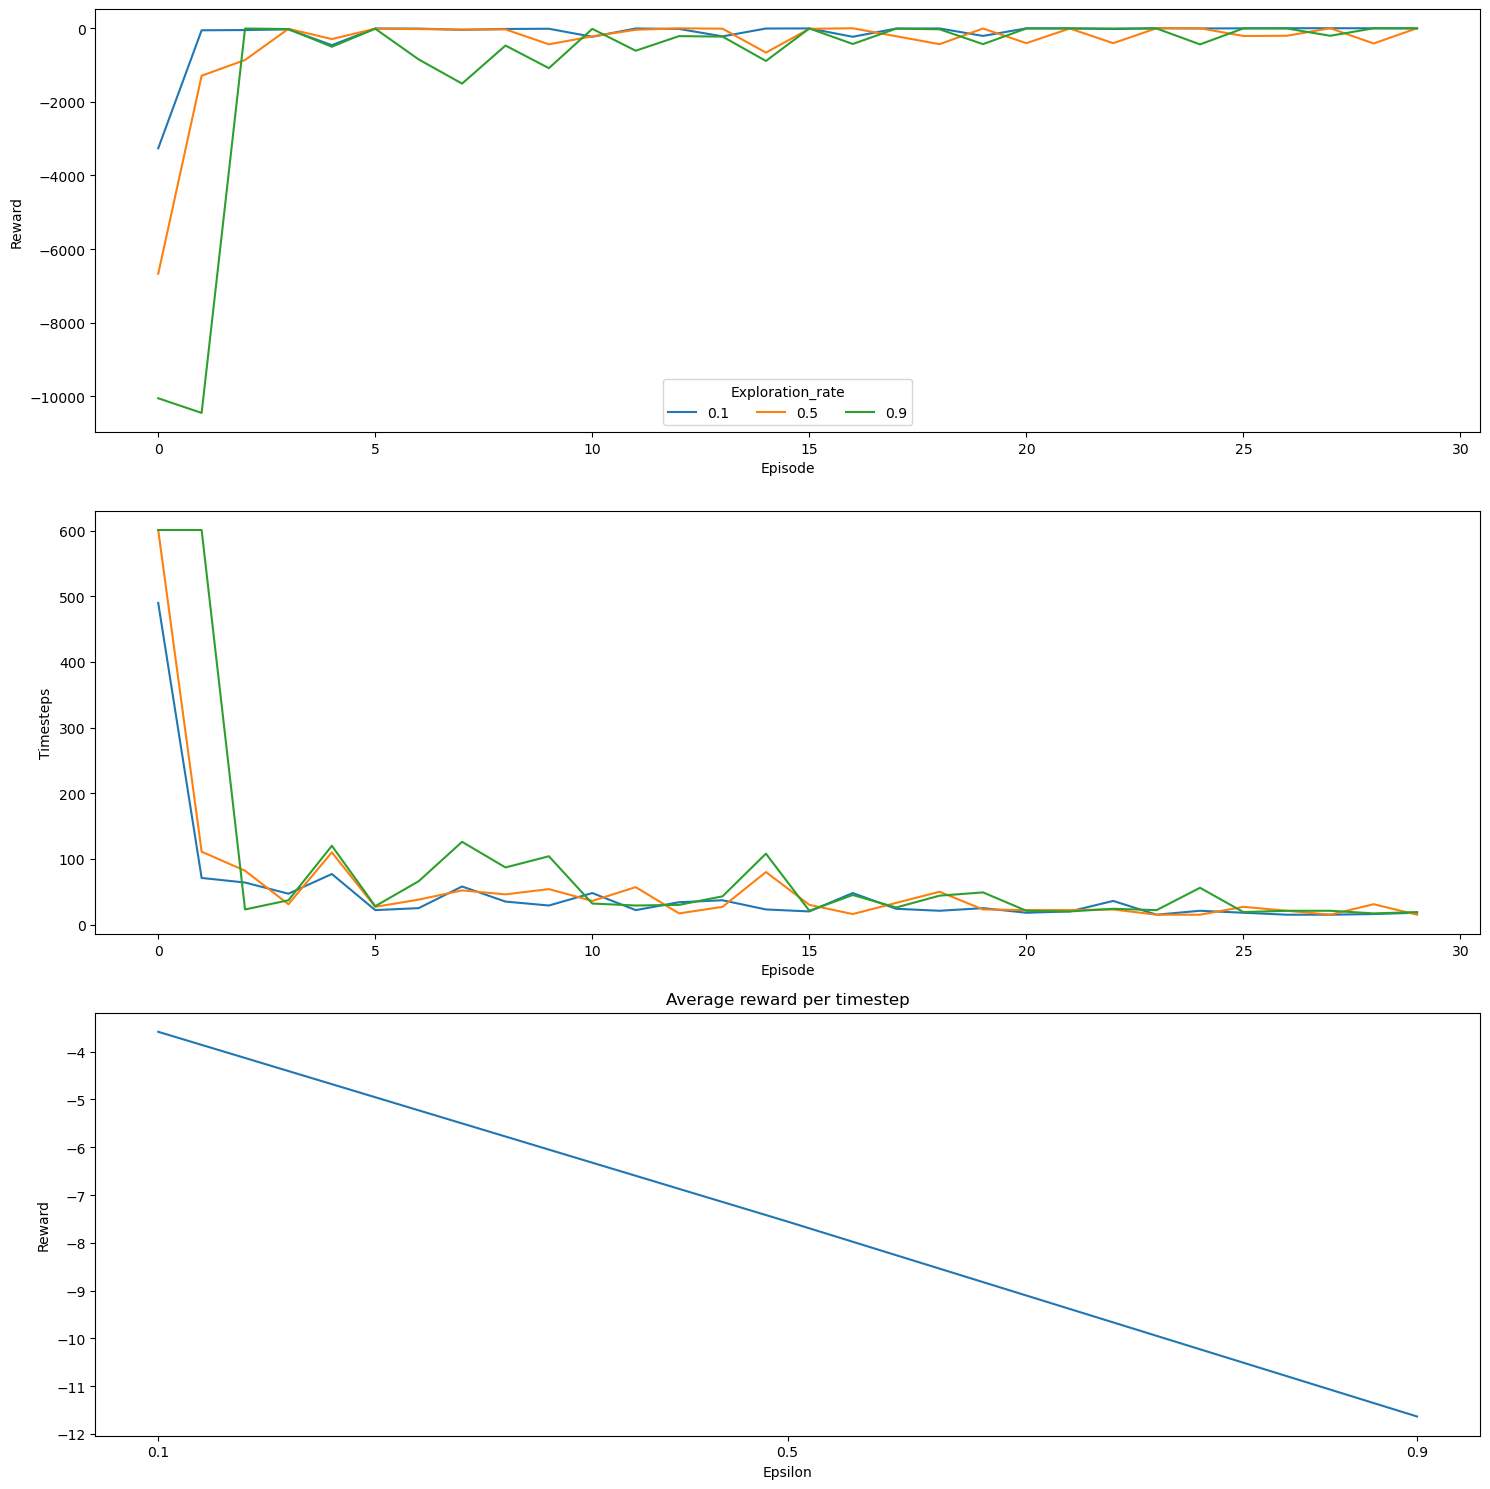

In [175]:
# Hyperparameter tuning for Epsilon
# cliff-v0 properties for ActionMap
width = 12
height = 4

# Episode properties
episodes = 30

# Qagent properties
alphas = [0.1, 0.5, 0.9]
gammas = [0.1, 0.5, 0.9]
decay = 0.9995

# Q-learning
QLepsilons = [0.1, 0.5, 0.9]
QLpolicy = 0

# Initialize collections
QLepisode_rewards = []
QLepisode_timesteps = []

normalized = []
# Default values when not tuned
alpha = alphas[2]
gamma = gammas[2]
epsilon = QLepsilons[0]

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(15,15))


for epsilon in QLepsilons:
    # Initialize collections
    QLepisode_rewards = []
    QLepisode_timesteps = []
    QL_James = Qagent(env_states, env_actions, alpha=alpha, gamma=gamma, exploration_rate=epsilon, decay=decay, init_value=0, policy_rate=QLpolicy)

    print("Cliff opened for Qagent with Learning Rate {0} and Discount Factor {1}".format(alpha, gamma))
    for i in range(episodes):
        # Q-learning
        Qreward, Qtimestep = cliffwalk(QL_James)
        QLepisode_rewards.append(Qreward)
        QLepisode_timesteps.append(Qtimestep)
        #print("Q-Learning with reward {0} in {1} timesteps in episode {2}".format(Qreward, Qtimestep, i))

    env.close()
    ax1.plot(QLepisode_rewards, label="{}".format(epsilon))
    ax2.plot(QLepisode_timesteps, label="{}".format(epsilon))
    normalized.append(np.sum(QLepisode_rewards)/np.sum(QLepisode_timesteps))
    QLepisode_mean_rewards = moving_average(QLepisode_rewards, 10)
    QL_actionmap = CreateActionMap(QL_James.q_table, width, height)
    print('Total reward collected is {0} in {1} steps.'.format(np.sum(QLepisode_rewards),np.sum(QLepisode_timesteps)))
    print('The average reward per step is {}'.format(np.sum(QLepisode_rewards)/np.sum(QLepisode_timesteps)))
    print('|--------------------|')
    print('|Q-Learning Actionmap|')
    print('|--------------------|')
    print(QL_actionmap)
    print('---------------------------------------------------')
    print('')
print('Cliff closed')
ax1.set_ylabel('Reward')
ax2.set_ylabel('Timesteps')
ax1.set_xlabel('Episode')
ax2.set_xlabel('Episode')
ax3.plot(QLepsilons,normalized)
ax3.set_title('Average reward per timestep')
ax3.set_ylabel('Reward')
ax3.set_xlabel('Epsilon')
ax3.set_xticks(QLepsilons)
ax1.legend(title="Exploration_rate", loc='lower center', ncols=3)

fig.tight_layout()
plt.show()

Cliff opened for Qagent with Learning Rate 0.1, Discount Factor 0.1 and Exploration Rate 0.1
Total reward collected is -12056 in 8295 steps.
The average reward per step is -1.4534056660638939
|--------------------|
|Q-Learning Actionmap|
|--------------------|
[['v' '<' '^' '>' '<' '^' 'v' '<' '<' '>' '<' '^']
 ['>' '^' 'v' '<' '^' '<' '<' '<' '^' 'v' 'v' 'v']
 ['v' '>' '>' '<' '^' '<' '^' '<' '<' '<' '^' 'v']
 ['v' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X']]
---------------------------------------------------

Cliff opened for Qagent with Learning Rate 0.1, Discount Factor 0.1 and Exploration Rate 0.5
Total reward collected is -23293 in 7171 steps.
The average reward per step is -3.2482220052991213
|--------------------|
|Q-Learning Actionmap|
|--------------------|
[['^' '^' '<' 'v' 'v' '>' '<' '<' '<' '>' '<' '>']
 ['<' '^' '^' '>' 'v' 'v' '<' 'v' '>' '^' '>' '^']
 ['^' '>' '>' '^' '<' '^' '>' '^' '<' '<' '^' 'v']
 ['<' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X']]
---------------

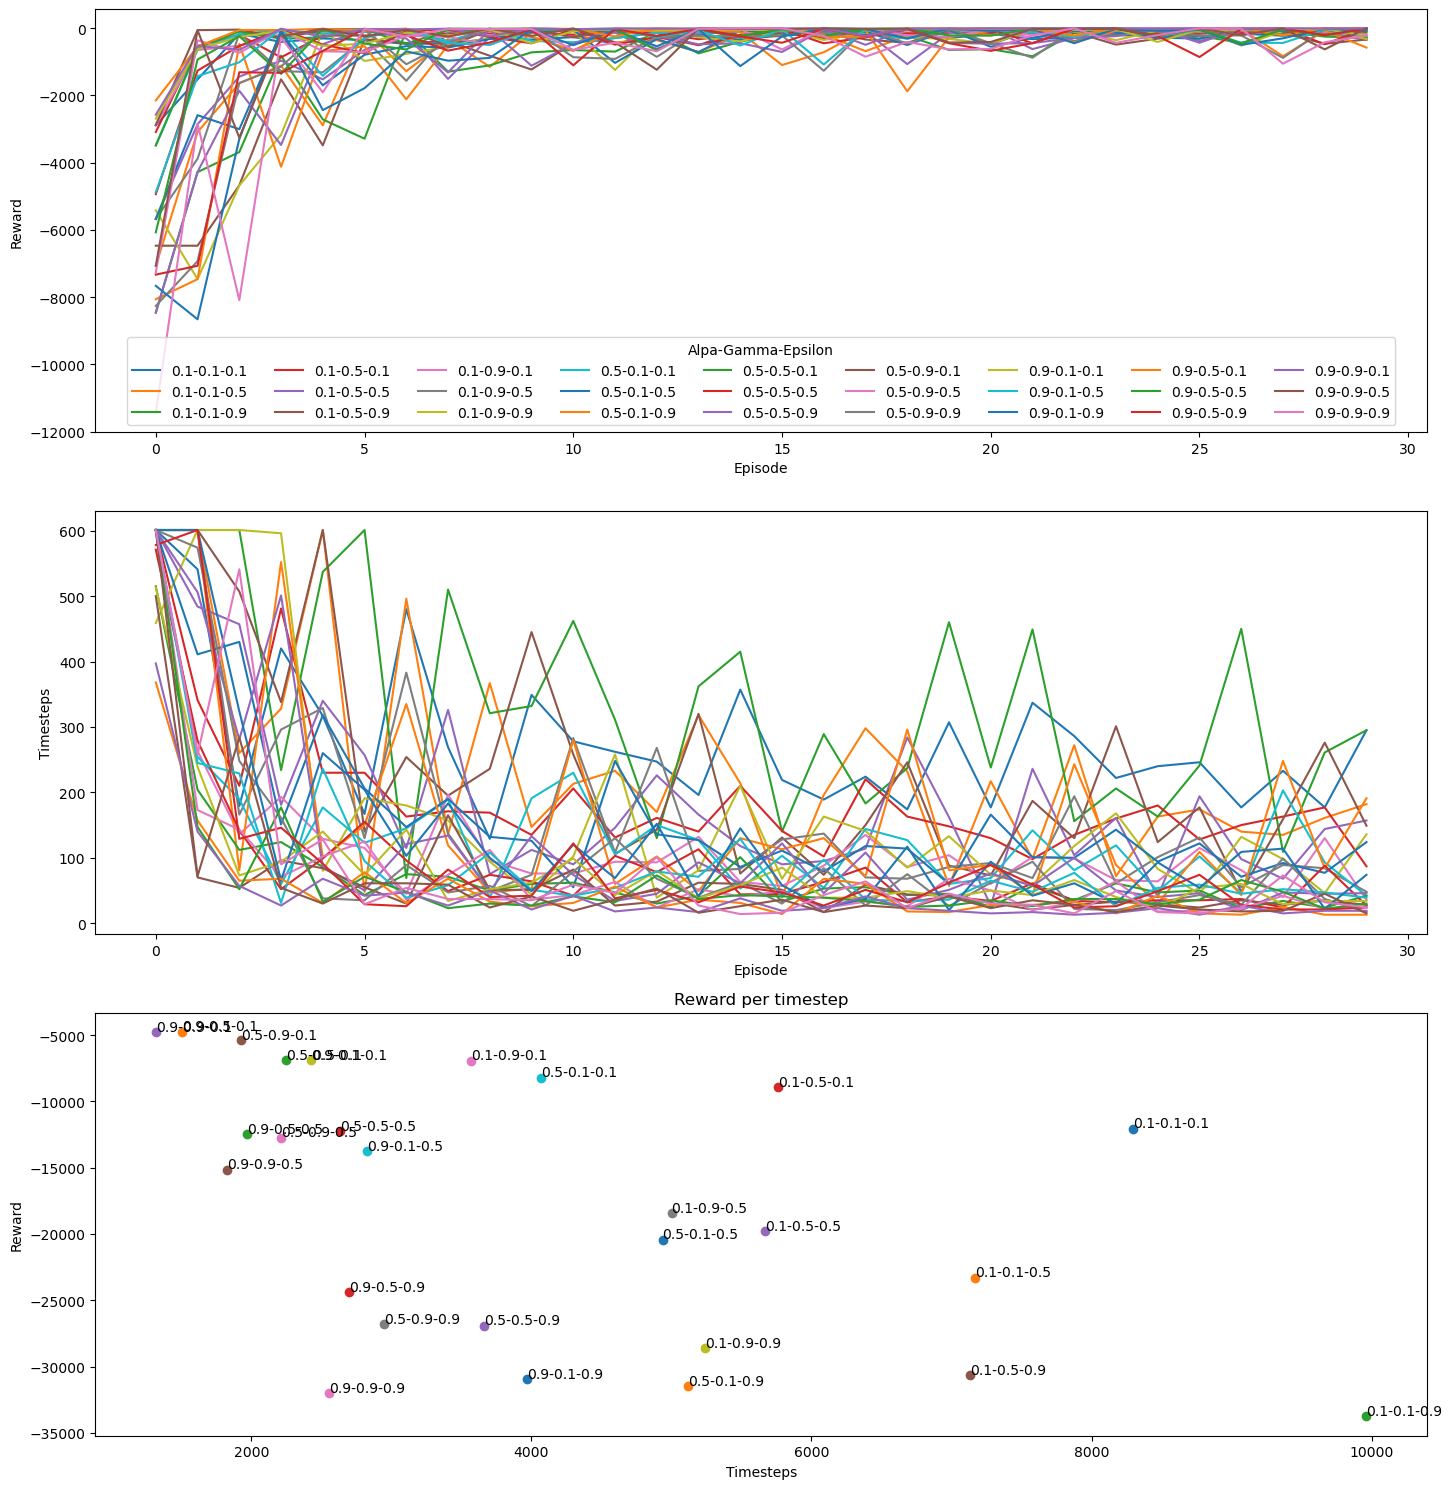

In [182]:
# Hyperparameter tuning for Alpha, Gamma & Epsilon
# cliff-v0 properties for ActionMap
width = 12
height = 4

# Episode properties
episodes = 30

# Qagent properties
alphas = [0.1, 0.5, 0.9]
gammas = [0.1, 0.5, 0.9]
decay = 0.9995

# Q-learning
QLepsilons = [0.1, 0.5, 0.9]
QLpolicy = 0

# Initialize collections
QLepisode_rewards = []
QLepisode_timesteps = []

normalized = pd.DataFrame(columns=["alpha","gamma","epsilon","normalized"])
area = []
# Default values when not tuned
alpha = alphas[2]
gamma = gammas[2]
epsilon = QLepsilons[0]

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(15,15))
for alpha in alphas:
    for gamma in gammas:
        for epsilon in QLepsilons:
            QLepisode_rewards = []
            QLepisode_timesteps = []
            QL_James = Qagent(env_states, env_actions, alpha=alpha, gamma=gamma, exploration_rate=epsilon, decay=decay, init_value=0, policy_rate=QLpolicy)

            print("Cliff opened for Qagent with Learning Rate {0}, Discount Factor {1} and Exploration Rate {2}".format(alpha, gamma, epsilon))
            for i in range(episodes):
                Qreward, Qtimestep = cliffwalk(QL_James)
                QLepisode_rewards.append(Qreward)
                QLepisode_timesteps.append(Qtimestep)
            env.close()
            ax1.plot(QLepisode_rewards, label="{0}-{1}-{2}".format(alpha,gamma,epsilon))
            ax2.plot(QLepisode_timesteps, label="{0}-{1}-{2}".format(alpha,gamma,epsilon))
            ax3.scatter(np.sum(QLepisode_timesteps),np.sum(QLepisode_rewards), label="{0}-{1}-{2}".format(alpha,gamma,epsilon))
            ax3.annotate("{0}-{1}-{2}".format(alpha,gamma,epsilon),(np.sum(QLepisode_timesteps),np.sum(QLepisode_rewards)+100))
            normalized.loc[-1] = [alpha, gamma, epsilon, np.sum(QLepisode_rewards)/np.sum(QLepisode_timesteps)]
            QLepisode_mean_rewards = moving_average(QLepisode_rewards, 10)
            QL_actionmap = CreateActionMap(QL_James.q_table, width, height)
            print('Total reward collected is {0} in {1} steps.'.format(np.sum(QLepisode_rewards),np.sum(QLepisode_timesteps)))
            print('The average reward per step is {}'.format(np.sum(QLepisode_rewards)/np.sum(QLepisode_timesteps)))
            print('|--------------------|')
            print('|Q-Learning Actionmap|')
            print('|--------------------|')
            print(QL_actionmap)
            print('---------------------------------------------------')
            print('')
print('Cliff closed')
ax1.set_ylabel('Reward')
ax2.set_ylabel('Timesteps')
ax1.set_xlabel('Episode')
ax2.set_xlabel('Episode')
# ax3 = fig.add_subplot(3,1,3, projection='3d')
# ax3.scatter(normalized['alpha'],normalized['gamma'],normalized['epsilon'], c=normalized['normalized'], cmap='jet')
# ax3.set_xlabel('Alpha')
# ax3.set_ylabel('Gamma')
# ax3.set_zlabel('Epsilon')
ax3.set_title('Reward per timestep')
ax3.set_ylabel('Reward')
ax3.set_xlabel('Timesteps')
#ax3.set_xticks(QLepsilons)
ax1.legend(title="Alpa-Gamma-Epsilon", loc='lower center', ncols=9)

fig.tight_layout()
plt.show()

**Hyperparameter tuning**

From the plot above we can see that the agent learns faster when the learning rate is higher. The agent learns faster when the discount factor is higher. The agent learns faster when the epsilon is lower.
For future experiments I will use the following hyperparameters: learning rate = 0.9, discount factor = 0.9, epsilon = 0.1.

Cliff opened for Qagent with Learning Rate 0.9 and decay 0.95
Total reward collected is -70896 in 60100 steps.
The average reward per step is -1.1796339434276206
|--------------------|
|Q-Learning Actionmap|
|--------------------|
[['v' '^' '^' 'v' '>' 'X' 'X' 'X' 'X' 'X' 'X' 'X']
 ['^' '^' 'v' '^' '>' 'X' 'X' 'X' 'X' 'X' 'X' 'X']
 ['v' '>' '>' '^' '>' 'X' 'X' 'X' 'X' 'X' 'X' 'X']
 ['^' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X']]
---------------------------------------------------

Cliff opened for Qagent with Learning Rate 0.9 and decay 0.995
Total reward collected is -7966 in 6678 steps.
The average reward per step is -1.1928721174004193
|--------------------|
|Q-Learning Actionmap|
|--------------------|
[['^' '^' '<' '>' '^' '<' 'v' '<' '>' '>' '>' '^']
 ['^' '^' '>' 'v' 'v' '^' '>' '^' '^' '>' 'v' 'v']
 ['^' '>' '>' '<' '>' '>' '>' '^' '^' '<' '>' 'v']
 ['v' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X']]
---------------------------------------------------

Cliff opened for Qagent

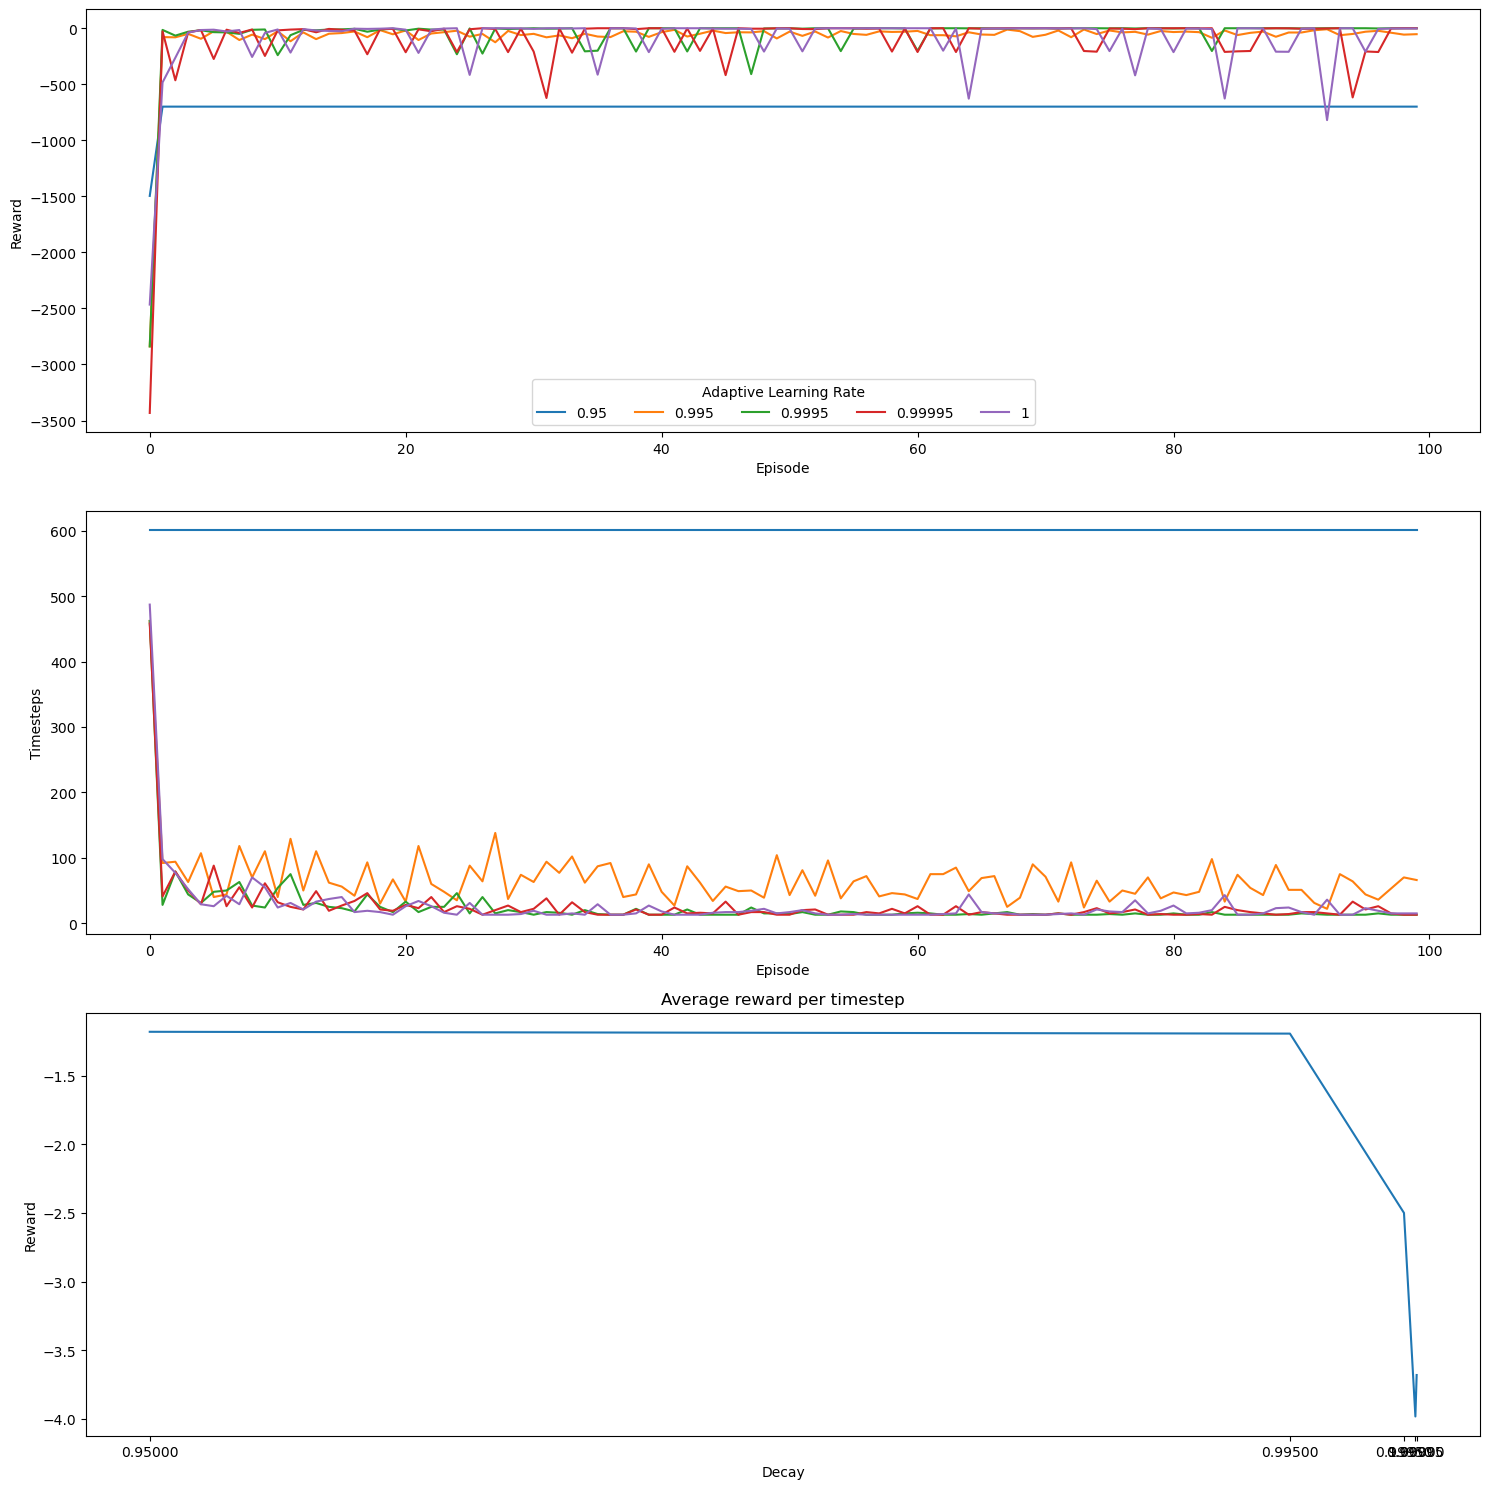

In [193]:
# Adaptive Learning Rate
# cliff-v0 properties for ActionMap
width = 12
height = 4

# Episode properties
episodes = 100

# Qagent properties
alphas = [0.1, 0.5, 0.9]
gammas = [0.1, 0.5, 0.9]
decays = [0.95, 0.995, 0.9995, 0.99995, 1]

# Q-learning
QLepsilons = [0.1, 0.5, 0.9]
QLpolicy = 0

# Initialize collections
QLepisode_rewards = []
QLepisode_timesteps = []

normalized = []
# Default values when not tuned
alpha = alphas[2]
gamma = gammas[2]
epsilon = QLepsilons[0]

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(15,15))


for decay in decays:
    # Initialize collections
    QLepisode_rewards = []
    QLepisode_timesteps = []
    QL_James = Qagent(env_states, env_actions, alpha=alpha, gamma=gamma, exploration_rate=epsilon, decay=decay, init_value=0, policy_rate=QLpolicy)

    print("Cliff opened for Qagent with Learning Rate {0} and decay {1}".format(alpha,decay))
    for i in range(episodes):
        # Q-learning
        Qreward, Qtimestep = cliffwalk(QL_James)
        QLepisode_rewards.append(Qreward)
        QLepisode_timesteps.append(Qtimestep)
        #print("Q-Learning with reward {0} in {1} timesteps in episode {2}".format(Qreward, Qtimestep, i))

    env.close()
    ax1.plot(QLepisode_rewards, label="{}".format(decay))
    ax2.plot(QLepisode_timesteps, label="{}".format(decay))
    normalized.append(np.sum(QLepisode_rewards)/np.sum(QLepisode_timesteps))
    QLepisode_mean_rewards = moving_average(QLepisode_rewards, 10)
    QL_actionmap = CreateActionMap(QL_James.q_table, width, height)
    print('Total reward collected is {0} in {1} steps.'.format(np.sum(QLepisode_rewards),np.sum(QLepisode_timesteps)))
    print('The average reward per step is {}'.format(np.sum(QLepisode_rewards)/np.sum(QLepisode_timesteps)))
    print('|--------------------|')
    print('|Q-Learning Actionmap|')
    print('|--------------------|')
    print(QL_actionmap)
    print('---------------------------------------------------')
    print('')
print('Cliff closed')
ax1.set_ylabel('Reward')
ax2.set_ylabel('Timesteps')
ax1.set_xlabel('Episode')
ax2.set_xlabel('Episode')
ax3.plot(decays,normalized)
ax3.set_title('Average reward per timestep')
ax3.set_ylabel('Reward')
ax3.set_xlabel('Decay')
ax3.set_xticks(decays)
ax1.legend(title="Adaptive Learning Rate", loc='lower center', ncols=5)

fig.tight_layout()
plt.show()

**Adaptive learning rate**

I have implemented different learning rates and learning rates below 0.995 don't work.
No decay is also not the best solution. The best decay was 0.9995.
The agent learned somewhat faster without taking too much negative rewards.

In [121]:
# Q-Learning VS SARSA
# cliff-v0 properties
width = 12
height = 4

# Qagent properties
alpha = 0.9
gamma = 0.9
decay = 0.9995

# Q-learning
QLepsilon = 0.1 # Greedy + Q-learning => little epsilon greedy otherwise the agent gets stuck in a loop
QLpolicy = 0

# SARSA
Sepsilon = 0.8
Spolicy = 0.2
# Episode properties
episodes = 200

# Initialize collections
QLepisode_rewards = []
QLepisode_timesteps = []
SAepisode_rewards = []
SAepisode_timesteps = []

# Start walking with two agents
QL_James = Qagent(env_states, env_actions, alpha=alpha, gamma=gamma, exploration_rate=QLepsilon, decay=decay, init_value=0, policy_rate=QLpolicy)
SA_James = Qagent(env_states, env_actions, alpha=alpha, gamma=gamma, exploration_rate=Sepsilon, decay=decay, init_value=0, policy_rate=Spolicy)

print("Cliff opened")
for i in range(episodes):
    # Q-learning
    Qreward, Qtimestep = cliffwalk(QL_James)
    QLepisode_rewards.append(Qreward)
    QLepisode_timesteps.append(Qtimestep)
    print("Q-Learning with reward {0} in {1} timesteps in episode {2}".format(Qreward, Qtimestep, i))
for i in range(episodes):       
    # SARSA
    Sreward, Stimestep = cliffwalk(SA_James)
    SAepisode_rewards.append(Sreward)
    SAepisode_timesteps.append(Stimestep)
    print("SARSA with reward {0} in {1} timesteps in episode {2}".format(Sreward, Stimestep, i))
env.close()

QLepisode_mean_rewards = moving_average(QLepisode_rewards, 10)
SAepisode_mean_rewards = moving_average(SAepisode_rewards, 10)

print("Final Q-table with Q-learning")
print(QL_James.q_table)

print("Final Q-table with SARSA")
print(SA_James.q_table)

QL_actionmap = CreateActionMap(QL_James.q_table, width, height)
print('|--------------------|')
print('|Q-Learning Actionmap|')
print('|--------------------|')
print(QL_actionmap)
print('---------------------------------------------------')
print('')
SA_actionmap = CreateActionMap(SA_James.q_table, width, height)
print('|---------------|')
print('|SARSA Actionmap|')
print('|---------------|')
print(SA_actionmap)
print('---------------------------------------------------')

print('Cliff closed')

Cliff opened
Q-Learning with reward -1617 in 430 timesteps in episode 0
Q-Learning with reward -322 in 125 timesteps in episode 1
Q-Learning with reward -74 in 75 timesteps in episode 2
Q-Learning with reward -41 in 42 timesteps in episode 3
Q-Learning with reward -183 in 85 timesteps in episode 4
Q-Learning with reward -22 in 23 timesteps in episode 5
Q-Learning with reward -51 in 52 timesteps in episode 6
Q-Learning with reward -43 in 44 timesteps in episode 7
Q-Learning with reward -46 in 47 timesteps in episode 8
Q-Learning with reward -34 in 35 timesteps in episode 9
Q-Learning with reward -44 in 45 timesteps in episode 10
Q-Learning with reward -157 in 59 timesteps in episode 11
Q-Learning with reward -40 in 41 timesteps in episode 12
Q-Learning with reward -154 in 56 timesteps in episode 13
Q-Learning with reward -35 in 36 timesteps in episode 14
Q-Learning with reward -34 in 35 timesteps in episode 15
Q-Learning with reward -28 in 29 timesteps in episode 16
Q-Learning with rewa

**Q-Learning vs SARSA**

The Q-learning agent follows the cliff edge and learns that it is better to fall off the cliff than to walk around it. The SARSA agent learns to avoid the cliff and walks around it. The SARSA agent learns a safer path, but it takes longer to learn.
The path followed by the agent can be seen in the actionmaps above.
Sometimes the agent gets stuck in a loop so I added some exploration to the QLearning Agent.
The decay needs to be very slow because the agent takes thousands of steps over multiple episodes to reach the goal.

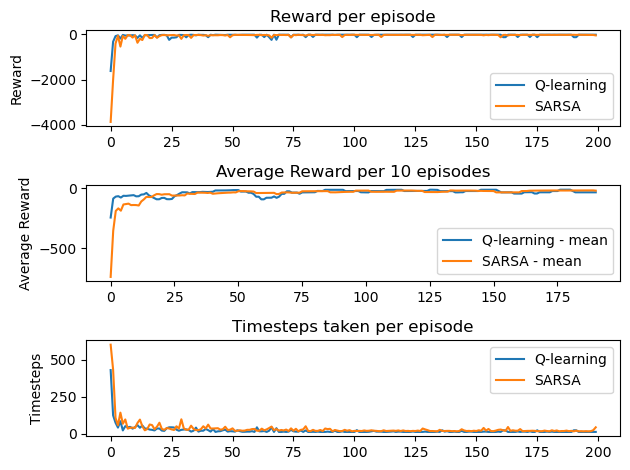

In [122]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(QLepisode_rewards, label='Q-learning')
ax1.plot(SAepisode_rewards, label='SARSA')
ax1.set_title('Reward per episode')
ax1.set_ylabel('Reward')
ax1.legend()

ax2.plot(QLepisode_mean_rewards, label='Q-learning - mean')
ax2.plot(SAepisode_mean_rewards, label='SARSA - mean')
ax2.set_title('Average Reward per 10 episodes')
ax2.set_ylabel('Average Reward')
ax2.legend()

ax3.plot(QLepisode_timesteps, label='Q-learning')
ax3.plot(SAepisode_timesteps, label='SARSA')
ax3.set_title('Timesteps taken per episode')
ax3.set_ylabel('Timesteps')
ax3.legend()
plt.tight_layout()
plt.show()

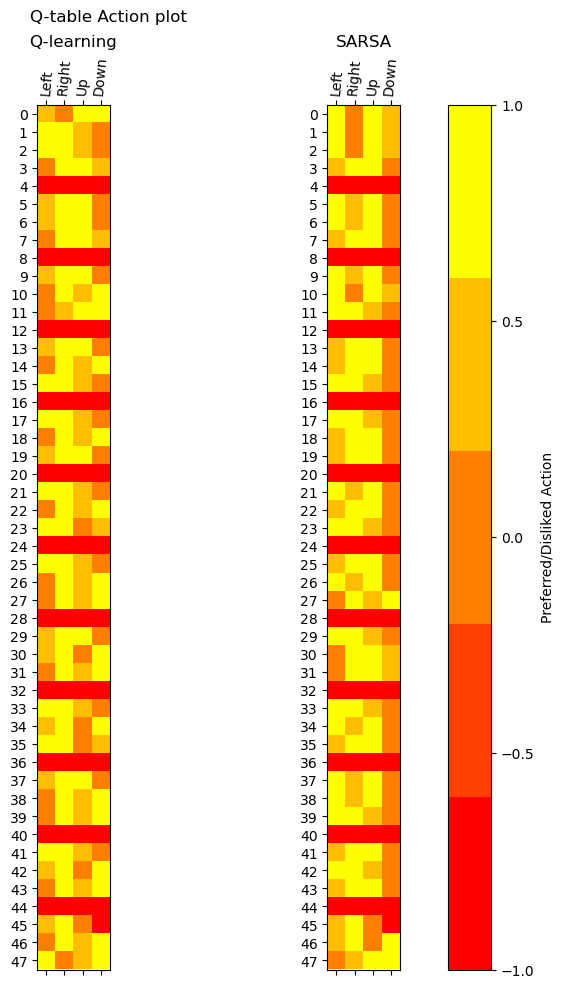

In [113]:
# plot the highest q-value per state
A = np.array(QL_James.q_table)
res = A.max(axis=1)
res2 = np.sort(A, axis=1)[:, -2]
res3 = np.sort(A, axis=1)[:, -3]
QL = np.zeros((env_states,env_actions))
for i in range(env_states):
    for j in range(env_actions):
        if A[i][j] == 0:
            QL[i][j] = -1
        elif A[i][j] == res[i]:
            QL[i][j] = 1
        elif A[i][j] == res2[i]:
            QL[i][j] = 0.6
        elif A[i][j] == res3[i]:
            QL[i][j] = 0.3   
        else:
            QL[i][j] = 0

B = np.array(SA_James.q_table)
res = B.max(axis=1)
res2 = np.sort(B, axis=1)[:, -2]
res3 = np.sort(B, axis=1)[:, -3]
SA = np.zeros((env_states,env_actions))
for i in range(env_states):
    for j in range(env_actions):
        if B[i][j] == 0:
            SA[i][j] = -1
        elif B[i][j] == res[i]:
            SA[i][j] = 1
        elif B[i][j] == res2[i]:
            SA[i][j] = 0.6
        elif B[i][j] == res3[i]:
            SA[i][j] = 0.3
        else:
            SA[i][j] = 0


import seaborn as sns
actions=("Left","Right","Up","Down")
fig, axes = plt.subplots(1,2, figsize=(10,10))
ax1, ax2 = axes
cmap = plt.get_cmap('autumn',5)
im1 = ax1.matshow(QL, cmap=cmap)
im2 = ax2.matshow(SA, cmap=cmap)
ax1.set_title("Q-learning")
ax2.set_title("SARSA")
ax1.set_yticks(range(env_states))
ax1.set_xticks(range(env_actions))
ax1.set_xticklabels(actions,rotation=85)
ax2.set_yticks(range(env_states))
ax2.set_xticks(range(env_actions))
ax2.set_xticklabels(actions,rotation=85)
plt.suptitle('Q-table Action plot')
plt.tight_layout()
plt.colorbar(im1,label="Preferred/Disliked Action", ax=axes.ravel().tolist(), ticks=np.linspace(-1,1,5))

In [115]:
# Changing the reward function


{'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 2}


## 2. The cartpole environment

Solve the cartpole environment by means of both Q-learning and SARSA. 
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

Q-learing and SARSA take discrete states as inputs. The cartpole environments outputs continuous state vectors. 
Therefore you will have to discretize these continuous state vectors. 
For example the cart position can vary in the range of -2.4 -> 2.4. You will have to discretize this range in a number of bins (for example 10 bins).
The numpy function 'digitize' can be used for discretization. More information about this function: https://numpy.org/doc/stable/reference/generated/numpy.digitize.html

- Implement the Q-learning algorithm. Write your own implementation and tune the hyperparameters (learning rate, discount factor, epsilon). Use epsilon decay if necessary. 
- Record the learning history. This means that for each episode you register the total episodic reward. After learning, plot the training history (x-axis = episode number; y-axis: total episodic reward). Especially in the beginning, the episodic rewards can be erratic because the agent is still exploring and has little knowledge of the environment. Therefore it can be a good idea to plot the moving average of the episodic rewards. For example, the average episodic reward achieved over 10 episodes.
- Check if you can make the agent learn faster by using an adaptive learning rate. You start with a high learning rate and you decrease gradually as the agent learns.
- Can you change the reward function in order to make the agent learn faster. For example by changing the reward values or by adding new rewards that make the reward function less sparse.

- Modify you Q-learing implementation to a SARSA implementation.

- Compare Q-learing with SARSA in terms of speed of learning, but especially in terms of the learned policy. 


In [4]:
import numpy as np
import pandas as pd
import random
import gym
import matplotlib.pyplot as plt
import copy

# Solving the cartpole environment

env_name = "CartPole-v1"
method_name='Q-learning'
env = gym.make(env_name)

In [14]:
observation = env.reset()
nr_actions = env.action_space.n
nr_states = env.observation_space.shape[0]
bin_size = 10
q_dims = (nr_states, nr_actions, bin_size)

# Set the environment limits
cartpos = 2.4
cartvel = 5
angle = 0.2095
anglevel = 5


#create bins
cp_bin = np.linspace(-cartpos, cartpos, bin_size)
cv_bin = np.linspace(-cartvel, cartvel, bin_size)
ap_bin = np.linspace(-angle, angle, bin_size)
av_bin = np.linspace(-anglevel, anglevel, bin_size)

def digitize(observation):
    cp = np.digitize(observation[0][0], cp_bin)
    cv = np.digitize(observation[0][1], cv_bin)
    ap = np.digitize(observation[0][2], ap_bin)
    av = np.digitize(observation[0][3], av_bin)

class Qagent:
    def __init__(self, q_dims):
        self.nr_states = q_dims[0]
        self.nr_actions = q_dims[1]
        self_bin_size = q_dims[2]
        self.q_table = np.zeros((10, 10, 10, 10, 2))
        print(q_table)



(4, 2, 10)
